In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model  import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor

In [59]:
df_train = pd.read_csv("../data/train.csv").drop(columns='id')

In [60]:
df_train['Weight Capacity (kg)'] = df_train['Weight Capacity (kg)'].fillna(df_train['Weight Capacity (kg)'].mean())
df_train.isna().sum()

Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)       0
Price                      0
dtype: int64

In [61]:
bins = [5, 10, 15, 20, 25, 31]
labels = ['5-10', '10-15', '15-20', '20-25', '25-30']

df_train['weight_category'] = pd.cut(df_train['Weight Capacity (kg)'], bins=bins, labels=labels, right=False)
df_train

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,weight_category
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875,10-15
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056,25-30
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320,15-20
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793,10-15
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312,15-20
...,...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749,10-15
299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819,25-30
299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364,10-15
299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080,5-10


In [62]:
df_train.isna().sum()

Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)       0
Price                      0
weight_category            0
dtype: int64

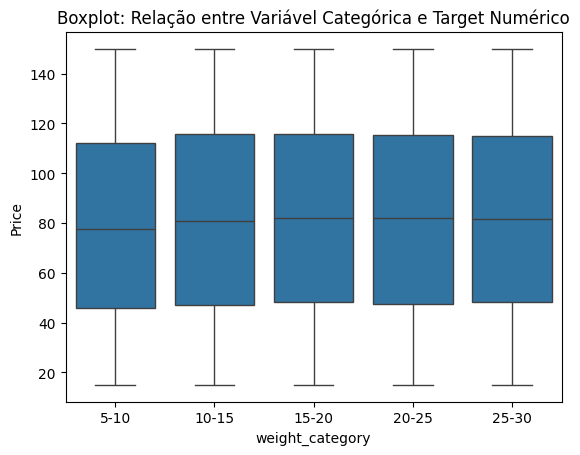

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exemplo de DataFrame com variável categórica 'category' e variável numérica 'target'
sns.boxplot(x='weight_category', y='Price', data=df_train)

# Exibir o gráfico
plt.title('Boxplot: Relação entre Variável Categórica e Target Numérico')
plt.show()


In [67]:
from scipy import stats

# Exemplo de DataFrame com variável categórica 'category' (mais de 2 categorias) e variável numérica 'target'
categories = [df_train[df_train['weight_category'] == cat]['Price'] for cat in df_train['weight_category'].unique()]

# Teste de Kruskal-Wallis
h_stat, p_value = stats.kruskal(*categories)

print(f"Estatística H: {h_stat}")
print(f"Valor p: {p_value:.4f}")


Estatística H: 170.01522427841826
Valor p: 0.0000


### NOVO PROCESSO DE PREPARAÇÃO: TRANSFORMANDO 'WEITHG CAPACITY (KG)' EM CATEGÓRICA

In [69]:
# Carregando os datasets para o treinamento e concantenando-os
df_1 = pd.read_csv("../data/train.csv")
df_2 = pd.read_csv("../data/training_extra.csv")
df = pd.concat([df_1, df_2], axis=0)
df = df.drop(columns='id')

In [ ]:
df_prep = data_preparation(df)

In [99]:
X = df_prep.drop(columns='Price')
y = df_prep['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"{rmse:.5f}")

38.89006


In [100]:
ridge = Ridge(alpha=100)
ridge.fit(X, y)

Ridge(alpha=100)

In [104]:
df_test = pd.read_csv("../data/test.csv")
ids = df_test['id']
df_test = df_test.drop(columns='id')
df_test_prep = data_preparation(df_test)

In [106]:
y_pred = ridge.predict(df_test_prep)
y_pred

array([82.0722187 , 82.83730671, 80.79363254, ..., 81.95253012,
       81.62450415, 81.95760243])

In [2]:
def csv_create(y_pred, ids):
      
    # Creating the submission DataFrame with 'id' and 'Transported'
    submission_data = pd.DataFrame({
        'id': ids,
        'Price': y_pred
    })
    
    # Checking for the 'submission' folder
    current_directory = os.getcwd()
    all_items = os.listdir(current_directory)
    folders = [item for item in all_items if os.path.isdir(os.path.join(current_directory, item))]
    
    # Checking if the 'submissions' folder exists, if not, create it
    if 'submissions' not in folders:
        submission_folder = os.path.join(current_directory, 'submissions')
        os.makedirs(submission_folder)
        
    # Getting the current date and time to create a unique filename
    now = datetime.now()
    filename = now.strftime("submission_%d_%m_%y_%H_%M.csv")
    
    # Saving the CSV in the 'submissions' folder with the date and time in the filename
    submission_data.to_csv(f'submissions/{filename}', index=False)
    
    print(f"File '{filename}' has been created in the 'submissions' folder!")

In [112]:
csv_create(y_pred, ids)

File 'submission_20_02_25_08_36.csv' has been created in the 'submissions' folder!


In [118]:
df_prep = data_preparation(df)

                Brand   Material    Size Compartments Laptop Compartment  \
0            Jansport    Leather  Medium            7                Yes   
1            Jansport     Canvas   Small           10                Yes   
2        Under Armour    Leather   Small            2                Yes   
3                Nike      Nylon   Small            8                Yes   
4              Adidas     Canvas  Medium            1                Yes   
...               ...        ...     ...          ...                ...   
3694313          Nike     Canvas  Medium            3                Yes   
3694314          Puma    Leather   Small           10                Yes   
3694315      Jansport     Canvas   Large           10                 No   
3694316          Puma     Canvas   Small            2                 No   
3694317  Under Armour  Polyester  Medium            2                Yes   

        Waterproof      Style  Color      Price weight_category  
0               No   

In [119]:
df_prep

,Price,Brand_Adidas,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Canvas,Material_Leather,Material_Nylon,Material_Polyester,...,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,weight_category_10-15,weight_category_15-20,weight_category_20-25,weight_category_25-30,weight_category_5-10
0,112.15875,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,68.88056,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,39.17320,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
3,80.60793,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
4,86.02312,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694313,104.74460,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3694314,122.39043,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3694315,148.18470,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3694316,22.32269,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


### REPENSANDO OS PASSOS DO PROCESSO

1. Preparação do dataset
2. Seleção dos atributos
3. Avaliação dos possíveis algoritmos
4. Otimização dos Hiperparâmetros
5. Predição da base de teste e submissão

In [3]:
def data_preparation_1(df):
    # Pré-processando as variáveis
    df_prep = df.copy()
    df_prep['Compartments'] = df_prep['Compartments'].astype(int).astype(object)

    cat_columns = df_prep.select_dtypes(include=['object']).columns
    for column in cat_columns:
        # Mostrando a distribuição antes do preenchimento
        category_percent = df_prep[column].value_counts(normalize=True)
        
        # Preenchendo valores NaN com base nas proporções existentes entre as categorias
        n_nan = df_prep[column].isna().sum()
        categories = category_percent.index
        proportions = category_percent.values

        new_values = np.random.choice(categories, size=n_nan, p=proportions)

        df_prep.loc[df_prep[column].isna(), column] = new_values

    # Preenchendo valores NaN de 'Weight Capacity (kg)' com a média
    df_prep['Weight Capacity (kg)'] = df_prep['Weight Capacity (kg)'].fillna(df_prep['Weight Capacity (kg)'].mean())
    
    # Criando a coluna categórica 'weight_categorical'
    bins = [5, 10, 15, 20, 25, 31]
    labels = ['5-10', '10-15', '15-20', '20-25', '25-30']
    df_prep['weight_category'] = pd.cut(df_prep['Weight Capacity (kg)'], bins=bins, labels=labels, right=False).astype('object')

    # Dropando a coluna numérica 'Weight Capacity (kg)'
    df_prep = df_prep.drop(columns='Weight Capacity (kg)')
    
    # Engenharia de atributos: get dummies para TODAS variáveis categóricas
    df_eng = df_prep.copy()
    cat_columns = df_eng.select_dtypes(include=['object']).columns
    for column in cat_columns:
        df_eng = pd.get_dummies(df_eng, columns=[column], dtype=int)
    
    return df_eng

In [4]:
def avaliar_relevancia_colunas(df):
    colunas_nao_relevantes = []
    
    for column in df.columns:
        
        # Verifica se a coluna é categórica
        if df[column].dtype == 'int32' or df[column].dtype == 'int64':
            
            if df[column].nunique() == 2:
                # Teste de Mann-Whitney U para variáveis binárias
                grupo_1 = df[df[column] == df[column].unique()[0]]['Price']
                grupo_2 = df[df[column] == df[column].unique()[1]]['Price']
                u_stat, p_value = stats.mannwhitneyu(grupo_1, grupo_2)
                
                if p_value > 0.05:
                    colunas_nao_relevantes.append(column)                    

            # Caso a coluna seja multiclasse (mais de 2 categorias)
            else:
                # Teste de Kruskal-Wallis para variáveis multiclasse
                categorias = [df[df[column] == cat]['Price'] for cat in df[column].unique()]
                h_stat, p_value = stats.kruskal(*categorias)
                
                if p_value > 0.05:
                    colunas_nao_relevantes.append(column)       
            
    # Retorna a lista de colunas não relevantes
    return colunas_nao_relevantes

In [5]:
def avaliar_modelos(df, target_column, frac=0.1, random_state=42):
    # Passo 1: Pegar um sample do dataset
    df_sample = df.sample(frac=frac, random_state=random_state)
    
    # Passo 2: Separar as variáveis independentes e o target
    X = df_sample.drop(columns=[target_column])
    y = df_sample[target_column]
    
    # Lista de modelos a serem testados
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest Regressor': RandomForestRegressor(random_state=random_state),
        'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=random_state),
        'CatBoost Regressor': CatBoostRegressor(iterations=1000, task_type='CPU', random_seed=random_state, verbose=False),
        'Ridge Regression': Ridge(),
        'ElasticNet Regression': ElasticNet(),
        'XGBoost Regressor': xgb.XGBRegressor(n_estimators=100, random_state=random_state),
        'LightGBM Regressor': lgb.LGBMRegressor(n_estimators=100, random_state=random_state)
    }
    
    # Passo 3: Testar os modelos com Cross-Validation e calcular o RMSE
    results = []
    for model_name, model in models.items():
        # Realiza a validação cruzada (K-Fold Cross-Validation)
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  # Usamos MSE negativo para maximizar o score
        
        # Converte de volta para o RMSE
        rmse_scores = np.sqrt(-cv_scores)  # O valor retornado é negativo, por isso precisamos inverter
        
        # Calcula a média e o desvio padrão dos RMSEs
        mean_rmse = np.mean(rmse_scores)
        std_rmse = np.std(rmse_scores)
        
        results.append((model_name, mean_rmse, std_rmse))
    
    # Passo 4: Printar o RMSE médio e o desvio padrão de cada algoritmo
    print("RMSE Médio e Desvio Padrão por Algoritmo (Cross-Validation):")
    for model_name, mean_rmse, std_rmse in results:
        print(f"{model_name}: {mean_rmse:.5f}")


### CODANDO TODAS AS ESTAPAS EM FUNÇÕES

In [6]:
# Carregamento do dataset de treino e o extra
df_train = pd.read_csv("../data/train.csv")
df_extra = pd.read_csv("../data/training_extra.csv")
df = pd.concat([df_train, df_extra], axis=0)
df = df.drop(columns='id')

### ALTERNATIVA 1: Todas as features recebendo o One Hot Encoding

In [7]:
# Preparação do dataset
df_prep = data_preparation_1(df)

In [8]:
# Avaliar a relevância das colunas para o target e excluir as colunas sem relevância
cols_to_exclude = avaliar_relevancia_colunas(df_prep)
df_prep = df_prep.drop(columns=cols_to_exclude)

In [194]:
# Testar os algoritmos de ML
avaliar_modelos(df_prep, 'Price', 0.1)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 319545, number of used features: 34
[LightGBM] [Info] Start training from score 81.471151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 319545, number of used features: 34
[LightGBM] [Info] Start training from score 81.391124
[LightGBM] [Warning] Found w

### ALTERNATIVA 2: 'SIZE' E 'WEIGHT_CATEGORY' RECEBENDO O LABEL ENCODING

In [35]:
def data_preparation_2(df):
    # Pré-processando as variáveis
    df_prep = df.copy()
    df_prep['Compartments'] = df_prep['Compartments'].astype(int).astype(object)

    cat_columns = df_prep.select_dtypes(include=['object']).columns
    for column in cat_columns:
        # Mostrando a distribuição antes do preenchimento
        category_percent = df_prep[column].value_counts(normalize=True)
        
        # Preenchendo valores NaN com base nas proporções existentes entre as categorias
        n_nan = df_prep[column].isna().sum()
        categories = category_percent.index
        proportions = category_percent.values

        new_values = np.random.choice(categories, size=n_nan, p=proportions)

        df_prep.loc[df_prep[column].isna(), column] = new_values

    # Preenchendo valores NaN de 'Weight Capacity (kg)' com a média
    df_prep['Weight Capacity (kg)'] = df_prep['Weight Capacity (kg)'].fillna(df_prep['Weight Capacity (kg)'].mean())
    
    # Criando a coluna categórica 'weight_categorical'
    bins = [5, 10, 15, 20, 25, 31]
    labels = ['5-10', '10-15', '15-20', '20-25', '25-30']
    df_prep['weight_category'] = pd.cut(df_prep['Weight Capacity (kg)'], bins=bins, labels=labels, right=False).astype('object')

    # Dropando a coluna numérica 'Weight Capacity (kg)'
    df_prep = df_prep.drop(columns='Weight Capacity (kg)')

    # Engenharia de Atributos
    df_eng = df_prep.copy()

    # Label Encoder para Size:
    mapping_size = {
    'Small': 0,
    'Medium': 1,
    'Large': 2
    }

    df_eng['Size_num'] = df_eng['Size'].map(mapping_size)
    df_eng = df_eng.drop(columns='Size')

    # Label Encoder para weight_category
    mapping_weight = {
    '5-10': 0,
    '10-15': 1,
    '15-20': 2,
    '20-25': 3,
    '25-30': 4
    }

    df_eng['weight_category_num'] = df_eng['weight_category'].map(mapping_weight)
    df_eng = df_eng.drop(columns='weight_category')

    # Engenharia de atributos: get dummies para TODAS variáveis categóricas
    
    cat_columns = df_eng.select_dtypes(include=['object']).columns
    for column in cat_columns:
        df_eng = pd.get_dummies(df_eng, columns=[column], dtype=int)
    
    return df_eng

In [36]:
# Carregamento do dataset de treino e o extra
df_train = pd.read_csv("../data/train.csv")
df_extra = pd.read_csv("../data/training_extra.csv")
df = pd.concat([df_train, df_extra], axis=0)
df = df.drop(columns='id')

In [37]:
df_prep = data_preparation_2(df)

In [40]:
# Avaliar a relevância das colunas para o target e excluir as colunas sem relevância
cols_to_exclude = avaliar_relevancia_colunas(df_prep)
df_prep = df_prep.drop(columns=cols_to_exclude)

In [ ]:
# Testar os algoritmos de ML
avaliar_modelos(df_prep, 'Price', 0.1)